# Predicting Turnover at the Hospital Level

This notebook contains the code used to predict RN turnover at greater than or less than 19%, the statewide average per hospital in Illinois. The first step is to combine data from hospital metrics (Illinois Hospital Report Cards) and patient surveys (Medicare) with employee ratings scraped from Glassdoor. I had already added county-level census data, opioid overdose rates, and number of homicides to the survey dataframe for use in the model.

In [4]:
import pandas as pd
df1 = pd.read_csv("EmployeeRatings_cleaned.csv")
df2 = pd.read_csv("SurveyData_cleaned.csv")
df1.shape #184, 8
df2.shape #184, 27
mergedata2 = pd.merge(df1,df2, on='Hosp_Name') #merge on standardized hospital names
mergedata2.head()
mergedata2 = mergedata2.drop(['Unnamed: 0', 'Percent RN Nursing Staff Hours (Medical-Surgical).1'], axis=1) #delete duplicate column
mergedata2.shape #184, 34
mergedata2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 183 entries, 0 to 182
Data columns (total 34 columns):
umbrella                                                                             183 non-null object
Hosp_Name                                                                            183 non-null object
rating_overall                                                                       182 non-null float64
rating_balance                                                                       182 non-null float64
rating_culture                                                                       182 non-null float64
rating_career                                                                        182 non-null float64
rating_comp                                                                          182 non-null float64
rating_mgmt                                                                          181 non-null float64
Doctors Always Communicated Well                 

In [6]:
# convert umbrella (y/n) to binary values

mergedata2.umbrella = mergedata2.umbrella.replace(to_replace=['N', 'Y'], value=[0, 1]).astype('category')
mergedata2.umbrella.value_counts()

0    121
1     62
Name: umbrella, dtype: int64

In [ ]:
#convert object data types to categories to use in decision tree-based modeling

mergedata2.Hosp_Name = mergedata2.Hosp_Name.astype('category')
mergedata2.County = mergedata2.County.astype('category')
mergedata2.Counties = mergedata2.Counties.astype('category')
mergedata2.info()

We have a combined data frame with data types that we can use in a predictive model. Next, we dig in a bit more and see if we need to do any cleaning or preprocessing before building a model.

## Exploratory Data Analysis

Text(0, 0.5, 'Density')

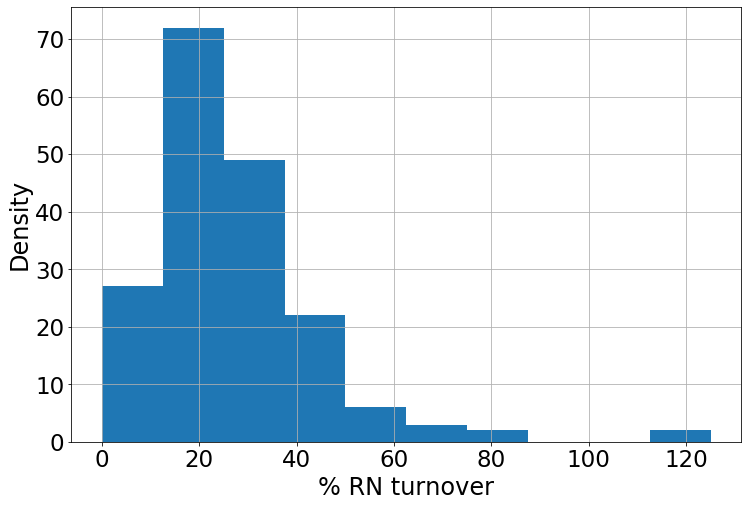

In [19]:
#target distribution is skewed, we will convert to binary for Hi/Lo classification and this helps to visualize the threshold
#mergedata2['RN Turnover'].hist()

import matplotlib
import matplotlib.pyplot as plt

params = {'axes.titlesize':'28',
          'xtick.labelsize':'23',
          'ytick.labelsize':'23'}
matplotlib.rcParams.update(params)
mergedata2['RN Turnover'].hist(figsize=(12, 8))
plt.xlabel('% RN turnover', size = 24)
plt.ylabel('Density', size = 24)

The turnover data are reported for the year 2018 and the distribution of our target (turnover) is left-skewed, with an average of 19%, but some hospitals with a net RN loss of zero and some with up to 125%, losing more nurses than they hired in 2018. Next we can check for signal in the data to see what might correlate with our target and have some predictive power.

In [20]:
mergedata2.corr()['RN Turnover'].sort_values(ascending=False)

RN Turnover                                                                          1.000000
Percent RN Nursing Staff Hours (Critical Care)                                       0.215417
Crim Homicides                                                                       0.193335
Num in County                                                                        0.193060
Opioid overdose                                                                      0.191685
Pop                                                                                  0.188453
Percentage of Nursing Hours Worked by Hospital Employed RNs (Critical Care)          0.184091
Median Length of Stay: Septicemia with Multiple Complications                        0.176245
Time from ED arrival to diagnostic evaluation by a qualified medical professional    0.136274
Total RN Nursing Hours per Patient Day (Critical Care)                               0.134961
Long                                                        

Next we can look at correlations between features to better think about what features we might need to engineer.

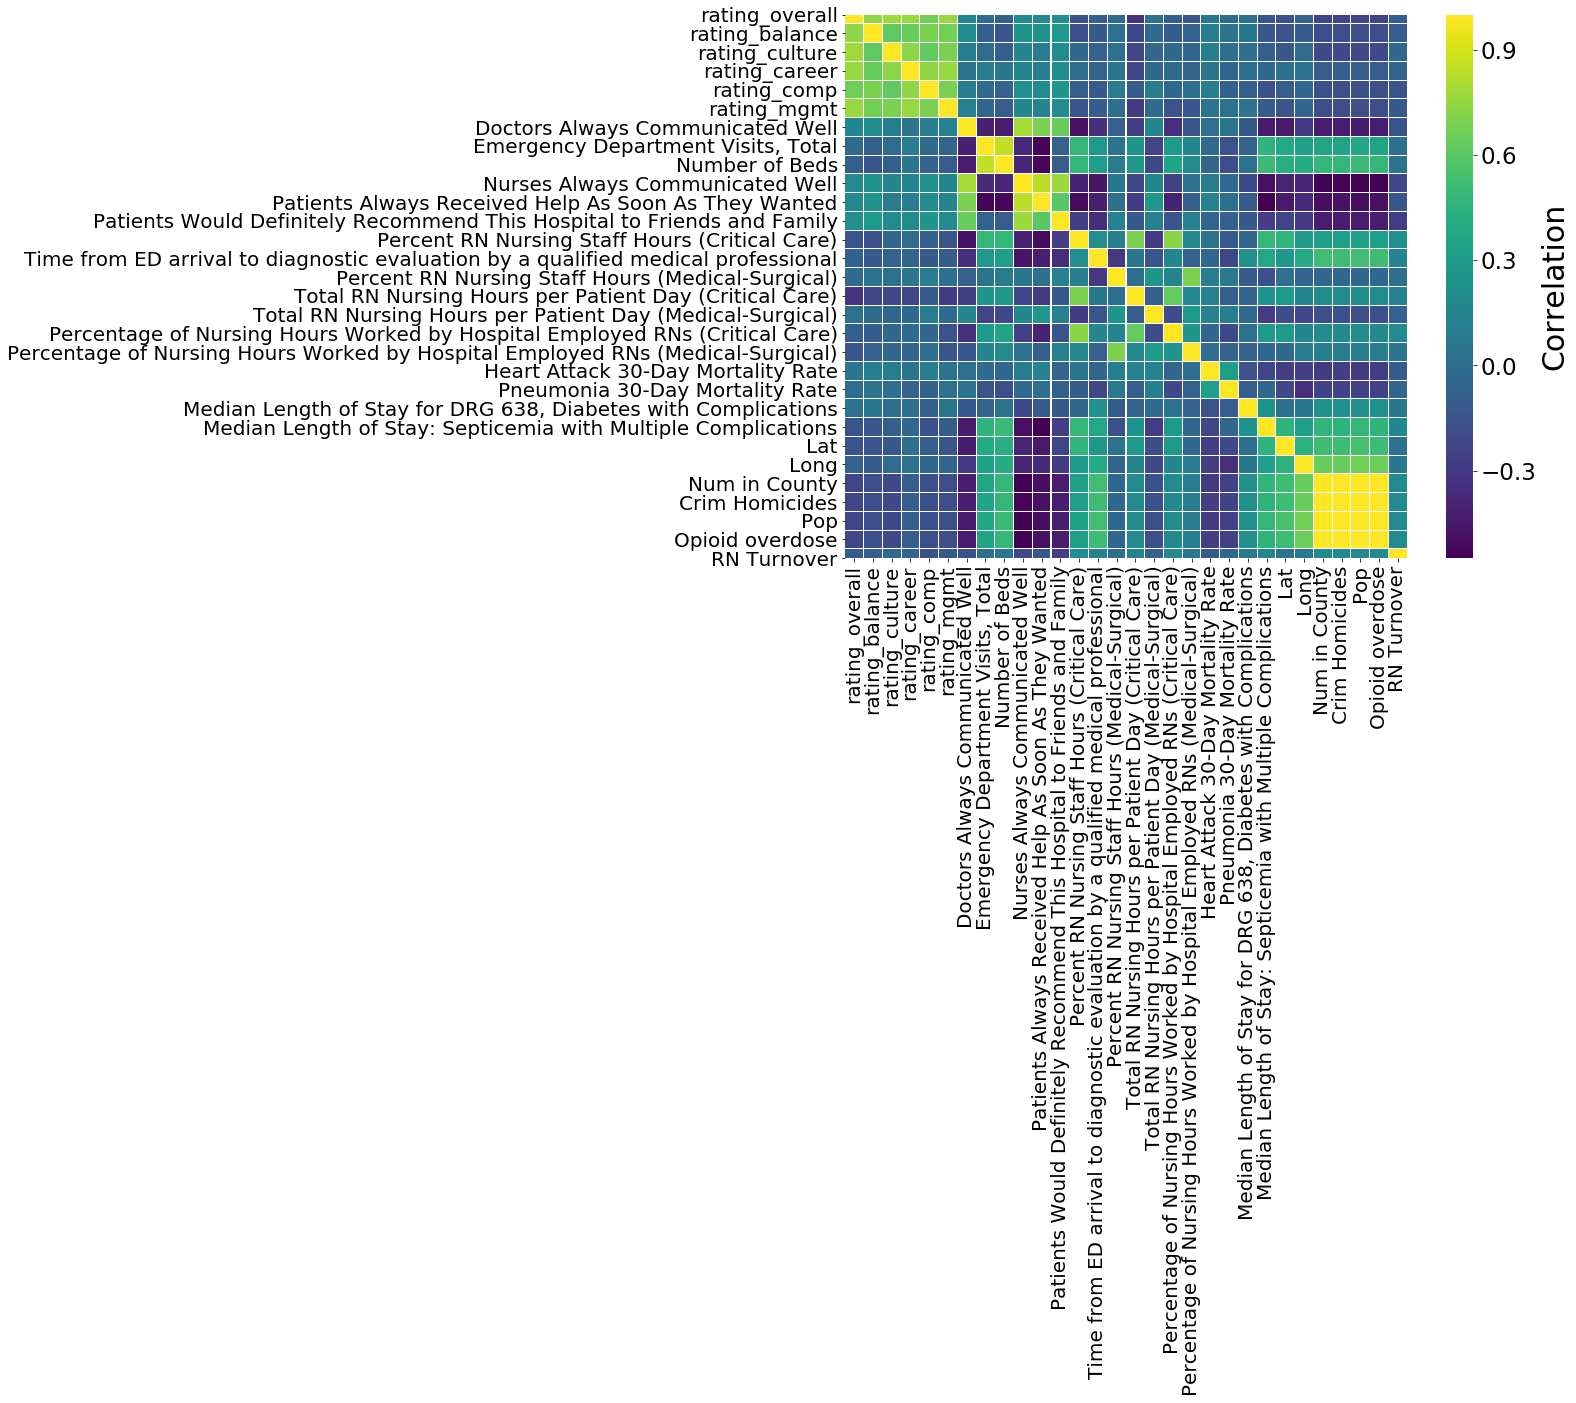

In [22]:
#check for correlated variables

import seaborn as sns
import matplotlib.pyplot as plt



fig, ax=plt.subplots(figsize=(20,26))

cax = sns.heatmap(mergedata2.corr(),annot=False,cmap='viridis',linewidths=0.05, square=True)

fig=plt.gcf()
fig.set_size_inches(14,10)

ax.figure.axes[-1].set_ylabel('Correlation', size=30)
#ax.figure.axes[-1].set_yticks(size=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.show()

Population, homicides, and opiod OD are highly correlated. Next we can engineer a new feature that incorporates homicides and population together with the idea that homicides are likley more common in metro areas, whereas opiod OD is more widespread across the state of Illinois, regardless of population.

In [23]:
#engineer a homicide rate feature
mergedata2['Homicide_Rate']=mergedata2['Crim Homicides']/mergedata2['Pop']
mergedata2=mergedata2.drop(mergedata2[['Crim Homicides', 'Pop']], axis=1)
mergedata2.head(4)

,umbrella,Hosp_Name,rating_overall,rating_balance,rating_culture,rating_career,rating_comp,rating_mgmt,Doctors Always Communicated Well,"Emergency Department Visits, Total",...,"Median Length of Stay for DRG 638, Diabetes with Complications",Median Length of Stay: Septicemia with Multiple Complications,Lat,Long,County,Counties,Num in County,Opioid overdose,RN Turnover,Homicide_Rate
0,0,Abraham Lincoln Memorial,3.0,5.000000,3.000000,2.000000,3.000000,3.000000,84.0,15573.0,...,2.5,3.0,40.15002,-89.37102,LOGAN,Logan,3.0,22.0,25.00,0.000000
1,1,Advocate BroMenn Medical Center,2.8,2.909091,2.952381,3.210526,3.166667,2.666667,81.0,28529.0,...,2.0,4.0,40.49736,-88.99038,MCLEAN,Other,1.0,62.0,38.46,0.000093
2,1,Advocate Christ Medical Center - Oak Lawn,3.9,3.500000,3.600000,3.600000,3.500000,3.200000,78.0,111224.0,...,2.0,5.0,41.72199,-87.73240,COOK,Cook,50.0,12541.0,22.14,0.000262
3,1,Advocate Condell Medical Center,4.0,3.900000,4.000000,3.800000,4.200000,3.700000,77.0,57728.0,...,3.0,6.0,42.27503,-87.95200,LAKE,Lake,5.0,588.0,27.69,0.000043


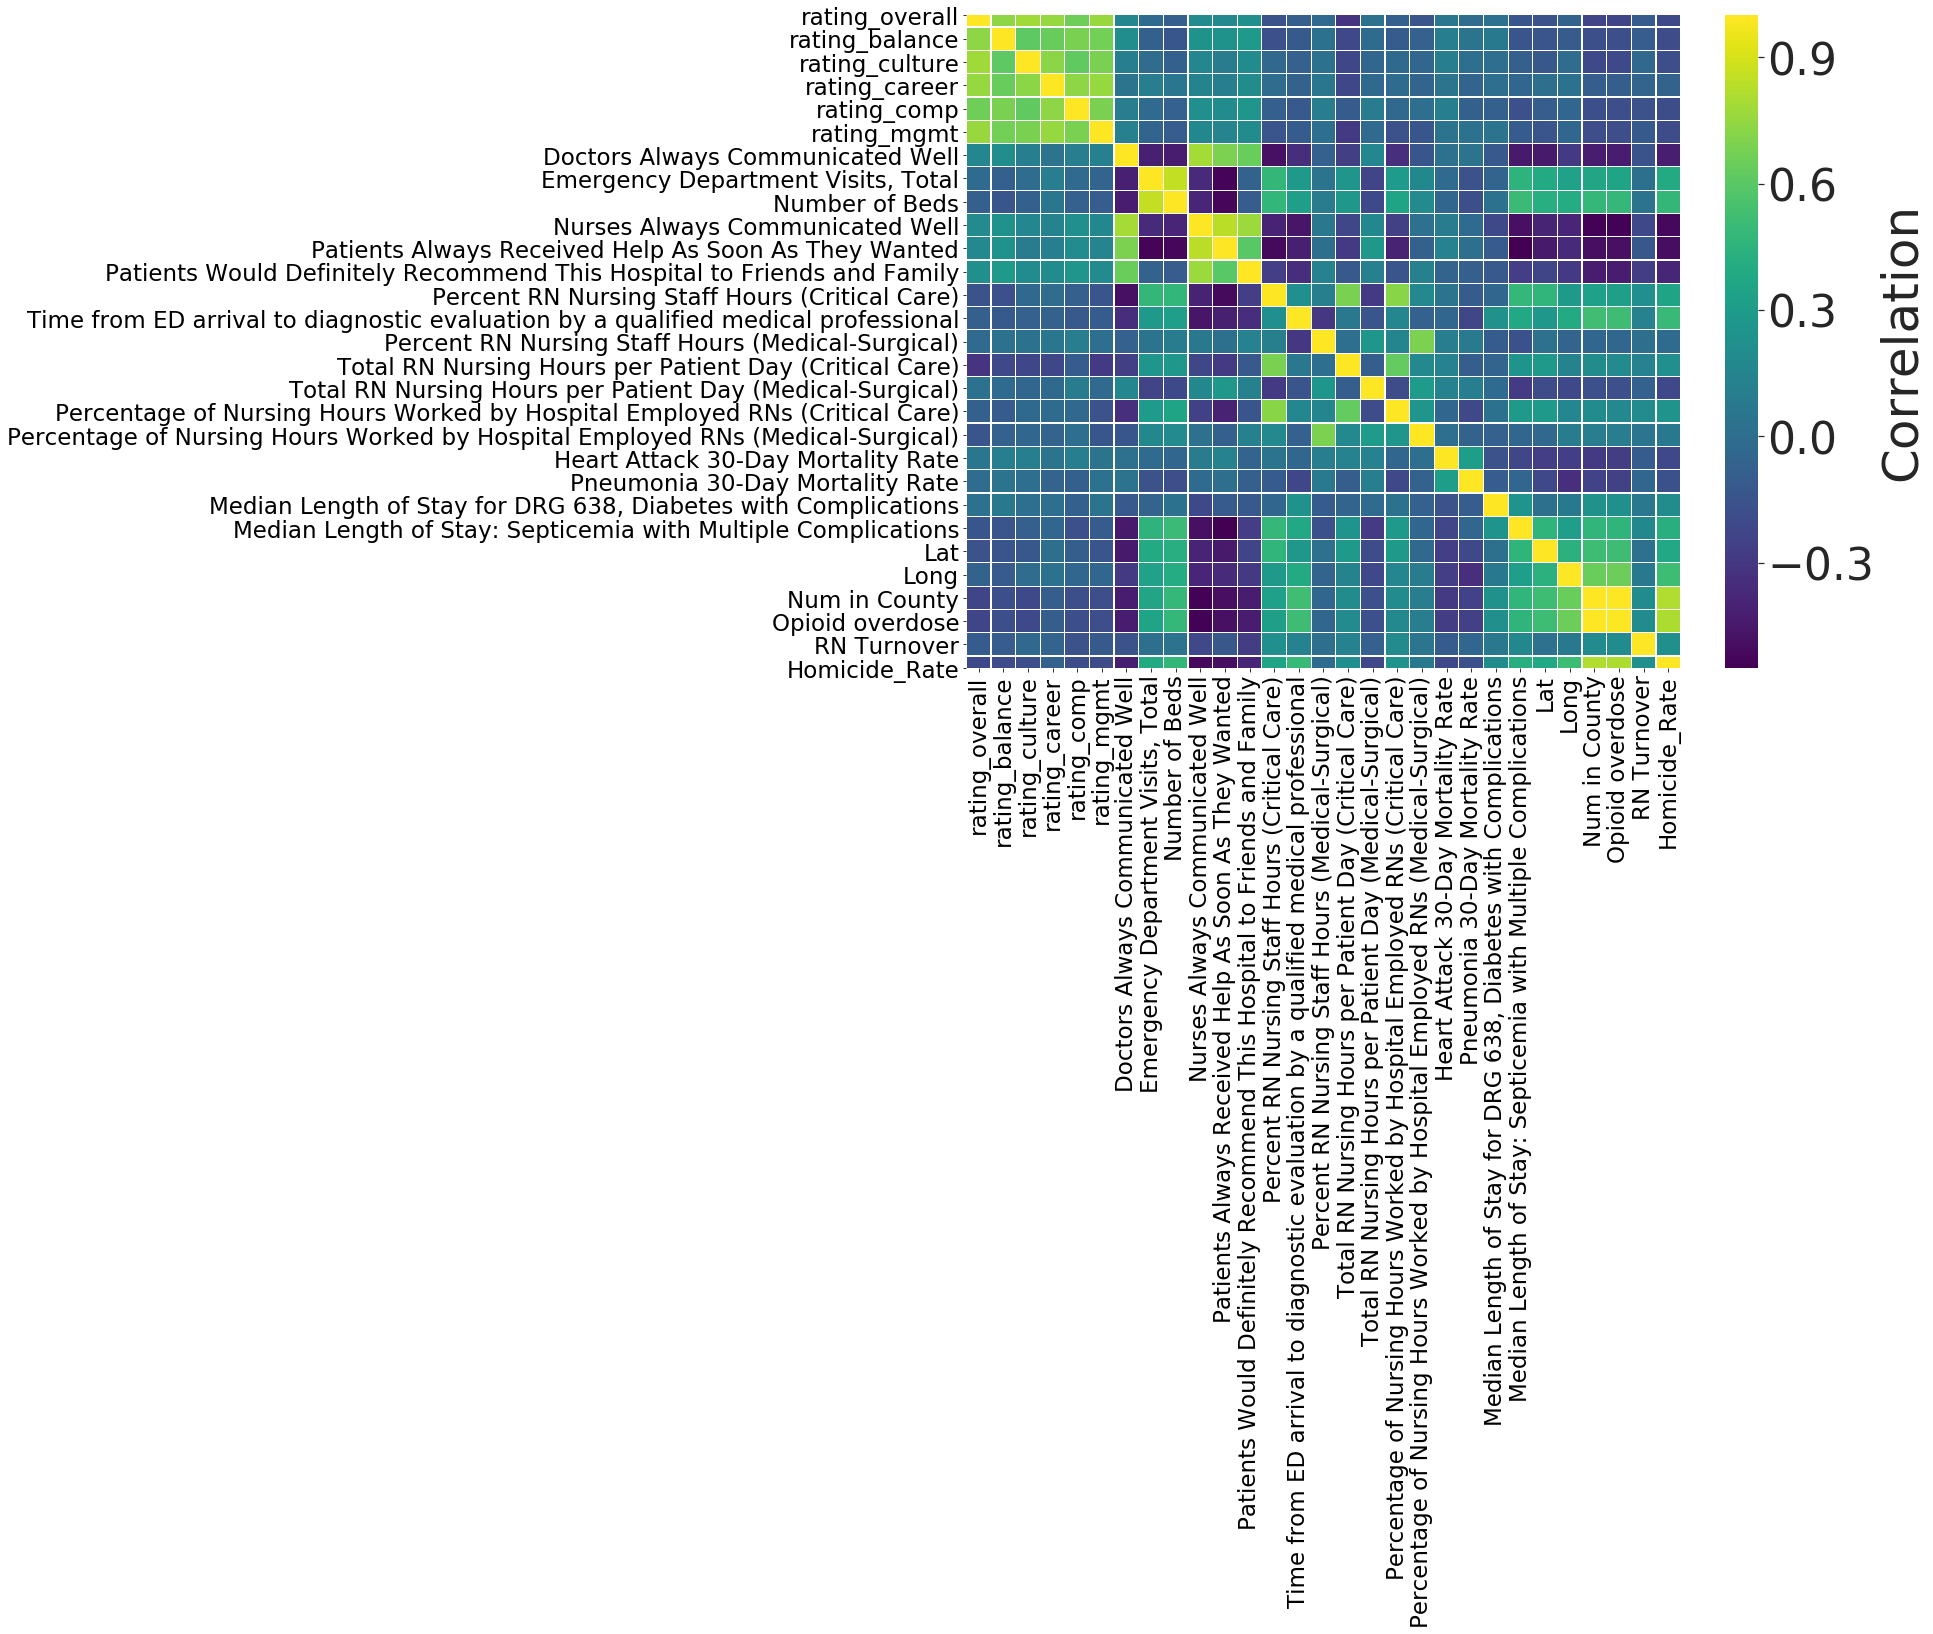

In [24]:
#re-check correlations
import seaborn as sns
import matplotlib.pyplot as plt
fig,axis=plt.subplots(figsize=(24,30))

sns.set(font_scale=4)
sns.heatmap(mergedata2.corr(),annot=False,cmap='viridis',linewidths=0.2,ax=axis)
axis.figure.axes[-1].set_ylabel('Correlation', size=50)
fig=plt.gcf()
fig.set_size_inches(16,12)

#plt.xticks(fontsize=14)
#plt.yticks(fontsize=14)
plt.show()

Before we commit to any specific model, it is important to check for outliers and look at the shape of distributions to help decide what models might be feasible with the data we have. We can do this by plotting box plots and densities of each feature to generate visuals of our data set.

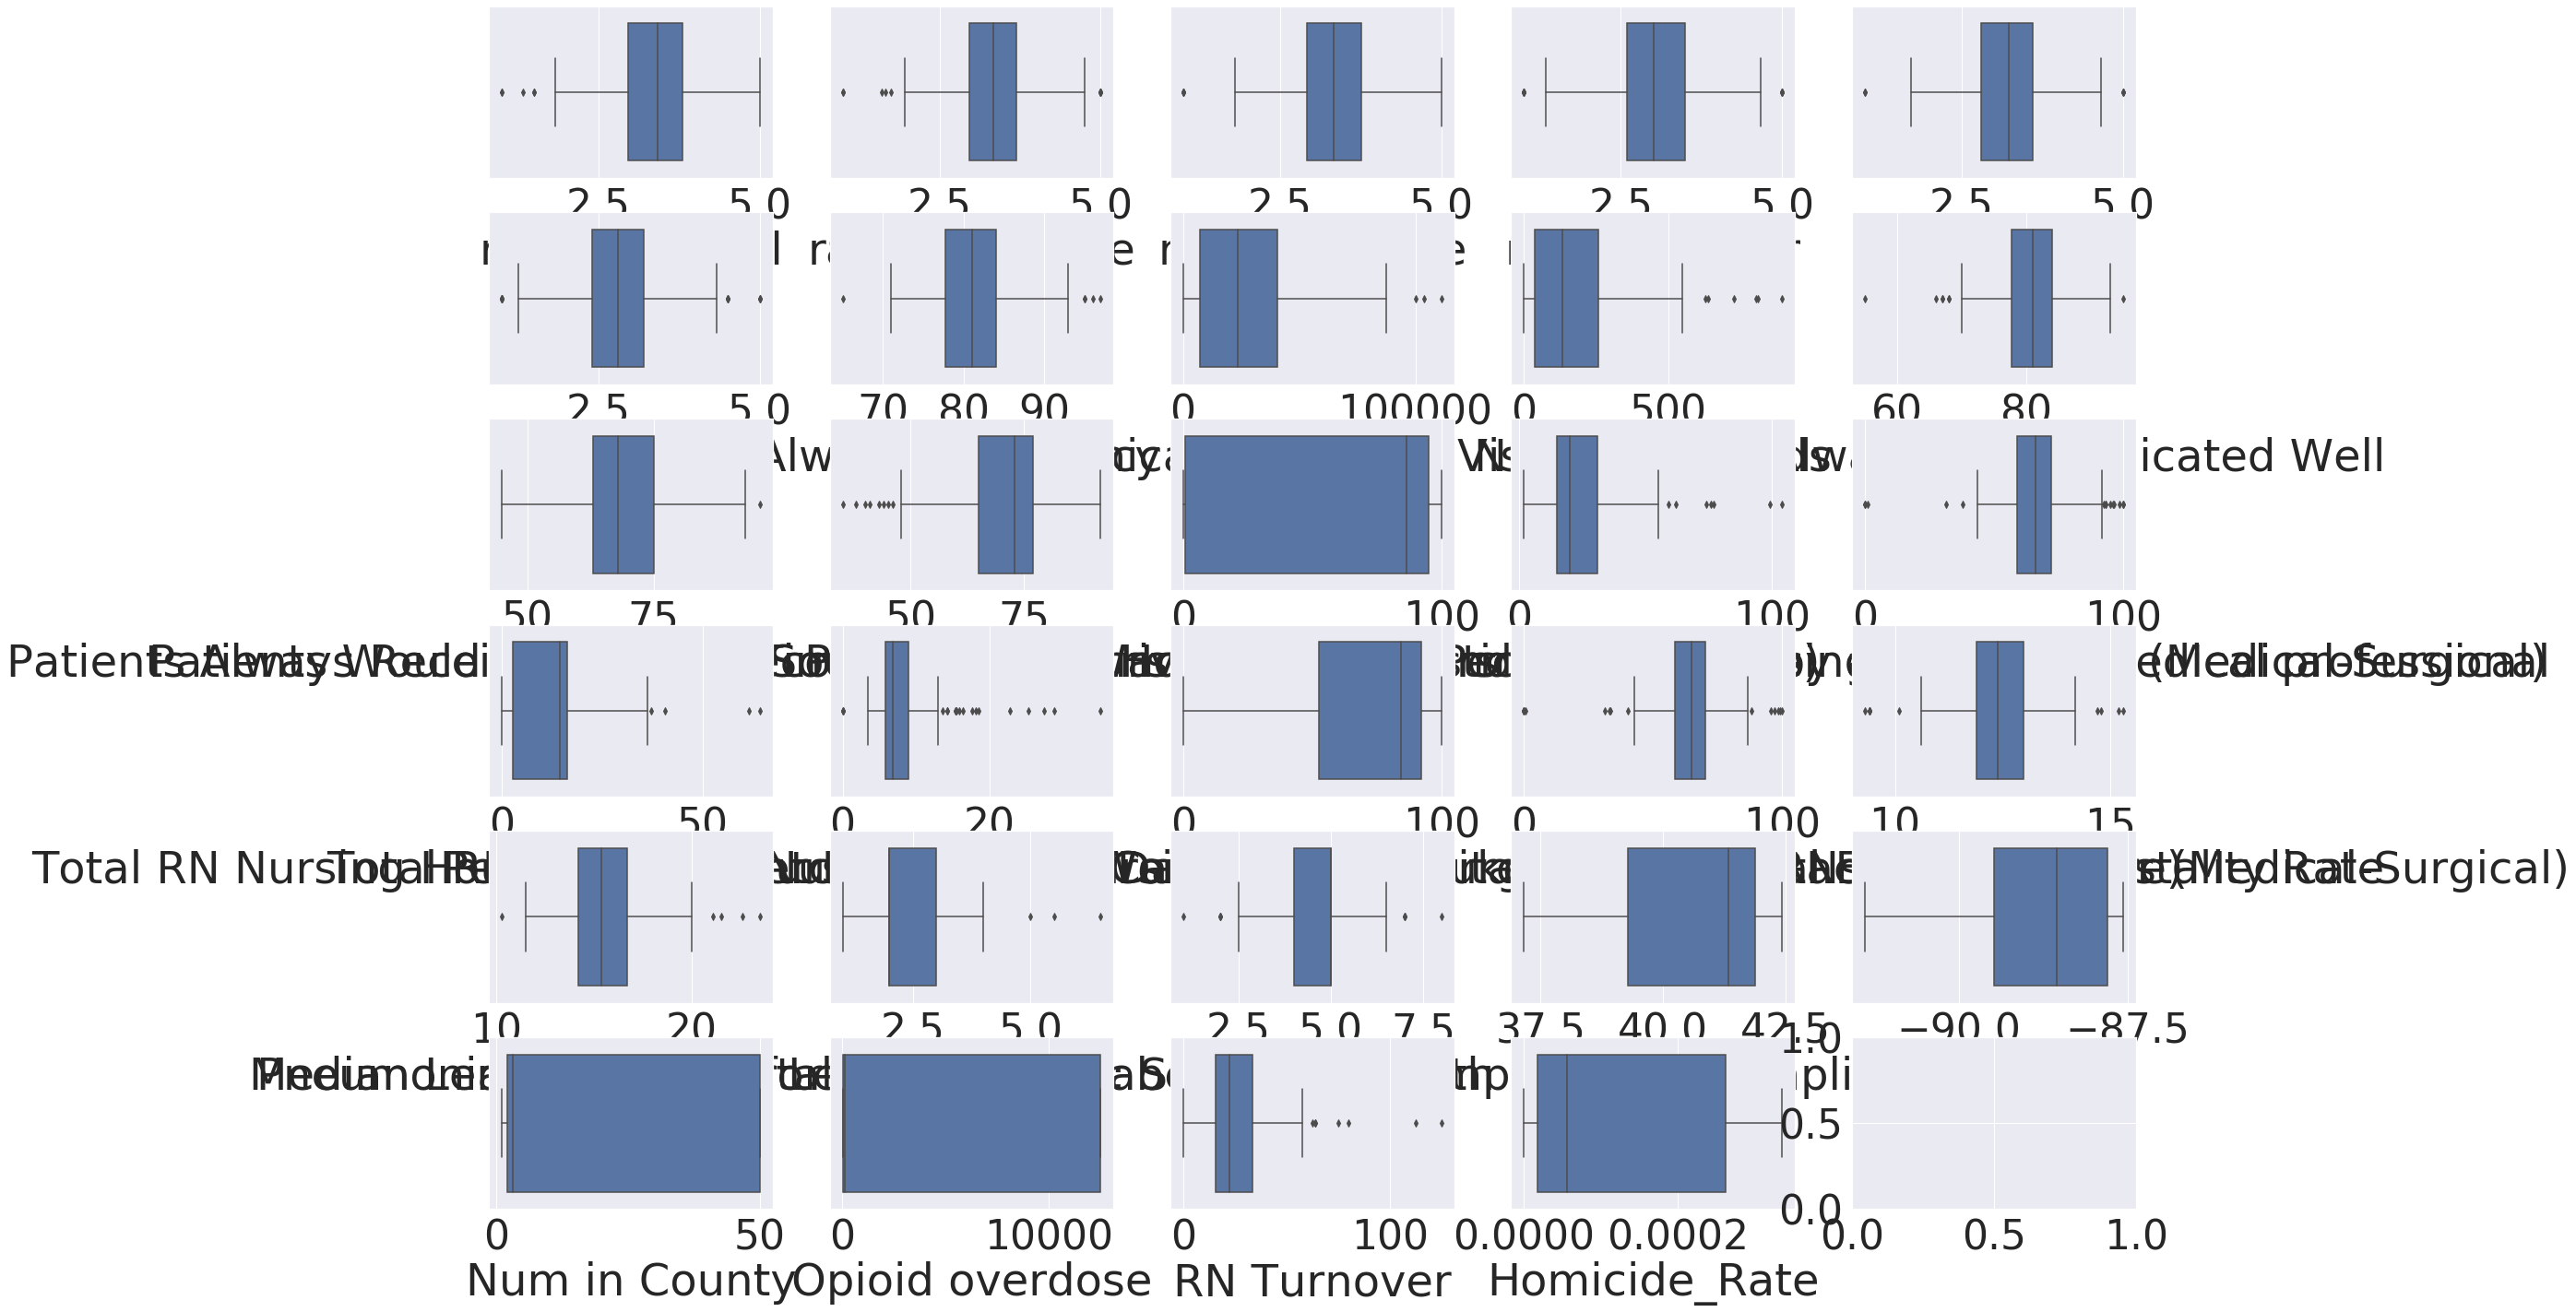

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns
boxplots = mergedata2.select_dtypes(include='number')
fig, axes = plt.subplots(nrows=6, ncols=5, figsize = (32,24))
for i, column in enumerate(boxplots.columns):
    sns.boxplot(boxplots[column],ax=axes[i//5,i%5])

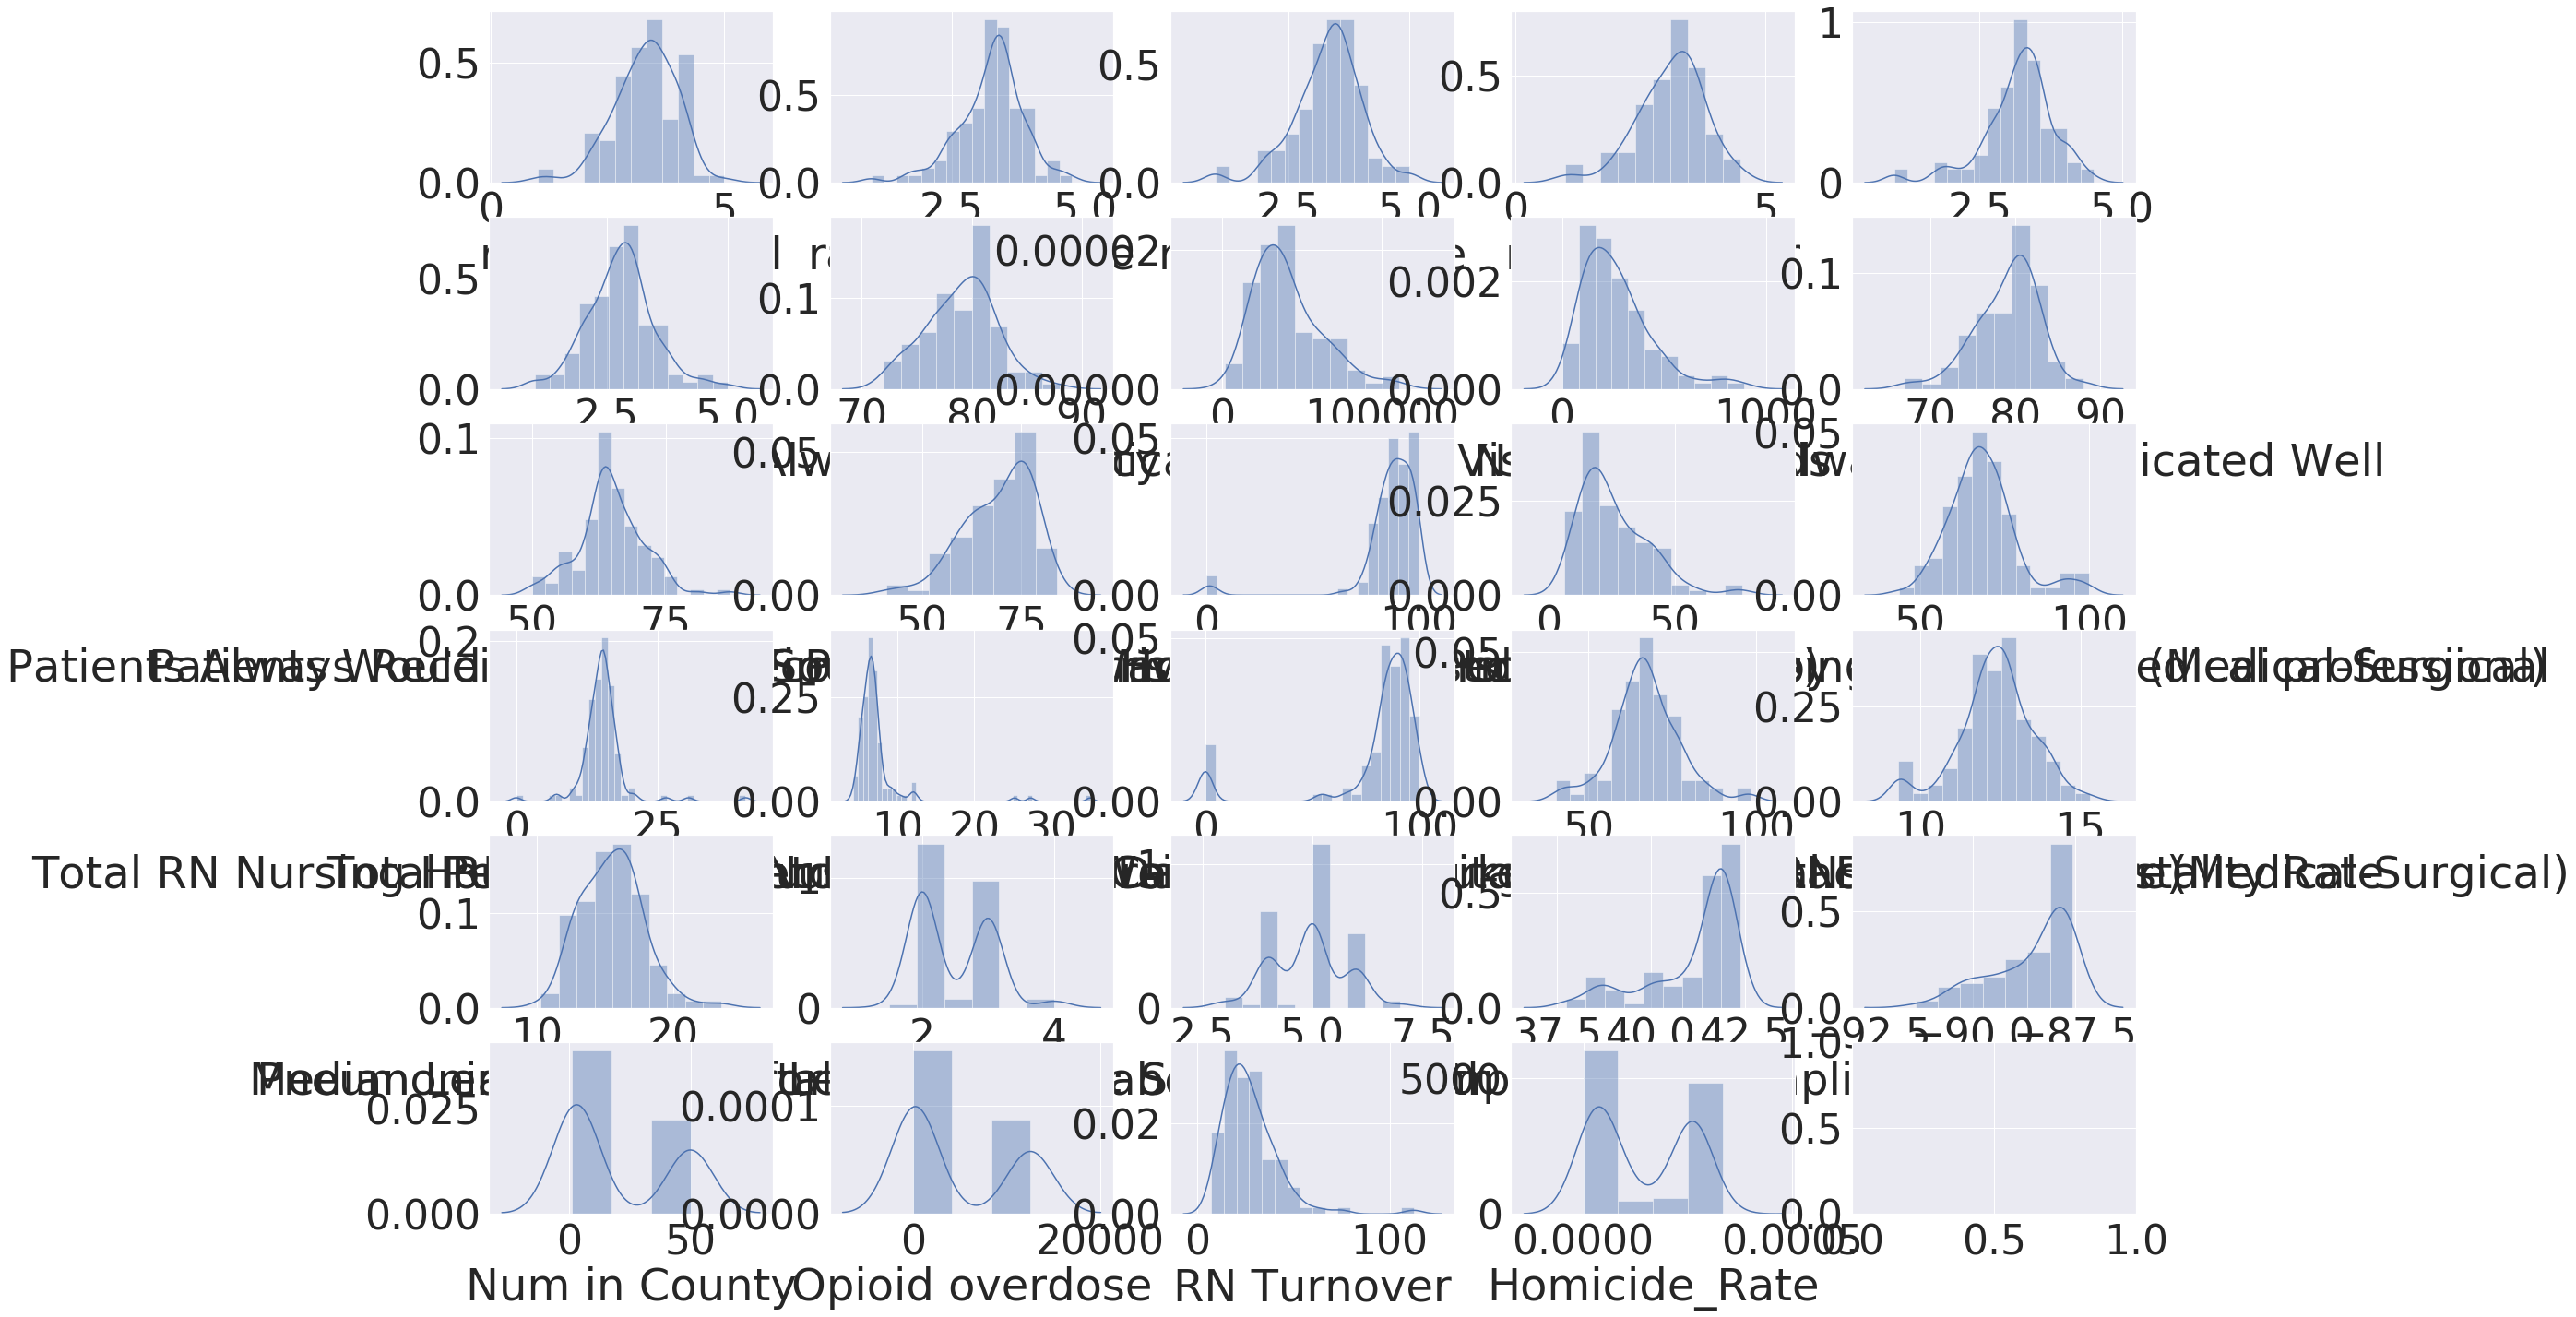

In [32]:
distplots = mergedata2.select_dtypes(include='number')
distplots = distplots.dropna()
fig, axes = plt.subplots(nrows=6, ncols=5, figsize = (32,24))
for i, column in enumerate(distplots.columns):
    sns.distplot(distplots[column], ax=axes[i//5,i%5])

Some features appear to be skewed, and many are of different scales; some range from 0-1, while others range from 0-10,000. One thing that will help is to impute any missing values with k-nearest neighbors. 

In [33]:
#impute missing values with k-nearest neighbors
mergedata3 = mergedata2.drop(['Hosp_Name', 'County', 'Counties'], axis=1)
from sklearn.impute import KNNImputer
knni = KNNImputer(n_neighbors=5)
mergedata3_filled = knni.fit_transform(mergedata3)
mergedata3_cols = mergedata3.columns
mergedata3_index = mergedata3.index
mergedata3_filled = pd.DataFrame(data=mergedata3_filled,index=mergedata3_index,columns=mergedata3_cols)
print(f'Total missing values before imputation {mergedata3.isna().sum().sum()},\nTotal missing values after imputation {mergedata3_filled.isna().sum().sum()}')

Total missing values before imputation 242,
Total missing values after imputation 0


## Random Forest Model

At this point, I decide to use a random forest classification model. Earlier trials with both linear and logistic regression indicate that it is difficult to predict turnover rates on a continuous scale. The data do not fit the assumptions of linear regression evan after scaling. There is still unequal variance and R2 values are near zero. It will be better to think about this prediction in terms of a binary classification problem where each hospital gets a predicted turnover either lower or higher than the 19% average. This will still be useful for hospitals to guage where they are in relation to other hospitals.

In [35]:
# Supress warning messages to clean up the notebook output
import warnings
warnings.filterwarnings('ignore')

In [36]:
#convert target variable to binary label; 0=<19%, 1=>19%

mergedata3_filled['label'] = mergedata3_filled['RN Turnover'].copy()

mergedata3_filled.label = mergedata3_filled.label.astype('int')
mergedata3_filled.label
mergedata3_filled.label[mergedata3_filled.label<=19] = 0
mergedata3_filled.label[mergedata3_filled.label>19] = 1

mergedata3_filled.head(7)

,umbrella,rating_overall,rating_balance,rating_culture,rating_career,rating_comp,rating_mgmt,Doctors Always Communicated Well,"Emergency Department Visits, Total",Number of Beds,...,Pneumonia 30-Day Mortality Rate,"Median Length of Stay for DRG 638, Diabetes with Complications",Median Length of Stay: Septicemia with Multiple Complications,Lat,Long,Num in County,Opioid overdose,RN Turnover,Homicide_Rate,label
0,0.0,3.0,5.000000,3.000000,2.000000,3.000000,3.000000,84.0,15573.0,25.0,...,18.8,2.5,3.0,40.15002,-89.37102,3.0,22.0,25.00,0.000000,1
1,1.0,2.8,2.909091,2.952381,3.210526,3.166667,2.666667,81.0,28529.0,221.0,...,16.6,2.0,4.0,40.49736,-88.99038,1.0,62.0,38.46,0.000093,1
2,1.0,3.9,3.500000,3.600000,3.600000,3.500000,3.200000,78.0,111224.0,802.0,...,14.2,2.0,5.0,41.72199,-87.73240,50.0,12541.0,22.14,0.000262,1
3,1.0,4.0,3.900000,4.000000,3.800000,4.200000,3.700000,77.0,57728.0,273.0,...,16.5,3.0,6.0,42.27503,-87.95200,5.0,588.0,27.69,0.000043,1
4,1.0,3.0,3.500000,3.800000,3.500000,4.000000,2.800000,95.0,3551.0,25.0,...,16.5,2.4,2.5,40.72143,-89.27188,1.0,5.0,0.00,0.000000,0
5,1.0,2.5,2.500000,2.500000,2.000000,2.000000,3.000000,82.0,41294.0,284.0,...,13.9,2.0,5.0,41.81852,-88.00811,5.0,1074.0,29.03,0.000024,1
6,1.0,5.0,4.500000,5.000000,4.500000,4.000000,4.500000,79.0,34808.0,176.0,...,15.3,2.0,5.0,42.19682,-88.17684,5.0,588.0,24.04,0.000043,1


In [37]:
mergedata3_filled.label.unique()

array([1, 0])

One major consideration for a random model is making sure that the binary classes are relatively balanced. We can do this by plotting the two classes side-by-side.

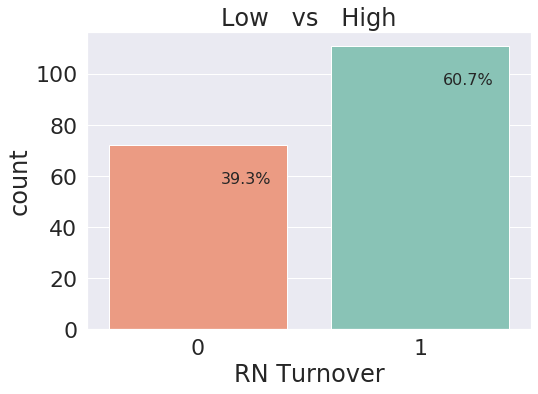

In [45]:
import matplotlib.pyplot as plt
import seaborn as sns

# function for countplot
def bplot_perc(col, data, title, xlabel, ax=None, hue=None):
    sns.set(font_scale=2)
    sns.countplot(col, data=data, ax=ax, hue=hue, palette= ["#fc9272", "#7fcdbb"]) 
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    total = len(mergedata3_filled)
    for p in ax.patches:
        height = p.get_height()
        ax.text(p.get_x() + p.get_width()/1.3, height - 15, '{:1.1f}%'.format((height/total)*100), ha="center", size=16) 
    plt.tight_layout()   
    plt.show()

# plot for target variable
f,ax=plt.subplots(figsize = (8,6))
bplot_perc(col='label', data=mergedata3_filled, title='Low   vs   High', xlabel='RN Turnover', ax=ax)

Now that we know the classes are relatively balanced, we can prepare the data for splitting prior to training a model. First, we drop Lat, Long, and turnover because the counties, population, homicides, and opiods already account for spatial variability whereas the binary label accounts for turnover.

In [48]:
mergedata4 = mergedata3_filled.drop(['Long', 'Lat','RN Turnover'], axis=1)
mergedata4.head()

,umbrella,rating_overall,rating_balance,rating_culture,rating_career,rating_comp,rating_mgmt,Doctors Always Communicated Well,"Emergency Department Visits, Total",Number of Beds,...,Percentage of Nursing Hours Worked by Hospital Employed RNs (Critical Care),Percentage of Nursing Hours Worked by Hospital Employed RNs (Medical-Surgical),Heart Attack 30-Day Mortality Rate,Pneumonia 30-Day Mortality Rate,"Median Length of Stay for DRG 638, Diabetes with Complications",Median Length of Stay: Septicemia with Multiple Complications,Num in County,Opioid overdose,Homicide_Rate,label
0,0.0,3.0,5.000000,3.000000,2.000000,3.000000,3.000000,84.0,15573.0,25.0,...,0.00,44.53,13.36,18.8,2.5,3.0,3.0,22.0,0.000000,1
1,1.0,2.8,2.909091,2.952381,3.210526,3.166667,2.666667,81.0,28529.0,221.0,...,81.23,66.35,13.50,16.6,2.0,4.0,1.0,62.0,0.000093,1
2,1.0,3.9,3.500000,3.600000,3.600000,3.500000,3.200000,78.0,111224.0,802.0,...,87.86,71.94,12.00,14.2,2.0,5.0,50.0,12541.0,0.000262,1
3,1.0,4.0,3.900000,4.000000,3.800000,4.200000,3.700000,77.0,57728.0,273.0,...,85.98,60.83,11.80,16.5,3.0,6.0,5.0,588.0,0.000043,1
4,1.0,3.0,3.500000,3.800000,3.500000,4.000000,2.800000,95.0,3551.0,25.0,...,0.00,86.03,13.06,16.5,2.4,2.5,1.0,5.0,0.000000,0


In [49]:
#add categorical variables back to dataframe
mergedata5 = mergedata2[['Hosp_Name', 'Counties']]
mergedata6 = mergedata4.join(mergedata5)
mergedata6.head()

,umbrella,rating_overall,rating_balance,rating_culture,rating_career,rating_comp,rating_mgmt,Doctors Always Communicated Well,"Emergency Department Visits, Total",Number of Beds,...,Heart Attack 30-Day Mortality Rate,Pneumonia 30-Day Mortality Rate,"Median Length of Stay for DRG 638, Diabetes with Complications",Median Length of Stay: Septicemia with Multiple Complications,Num in County,Opioid overdose,Homicide_Rate,label,Hosp_Name,Counties
0,0.0,3.0,5.000000,3.000000,2.000000,3.000000,3.000000,84.0,15573.0,25.0,...,13.36,18.8,2.5,3.0,3.0,22.0,0.000000,1,Abraham Lincoln Memorial,Logan
1,1.0,2.8,2.909091,2.952381,3.210526,3.166667,2.666667,81.0,28529.0,221.0,...,13.50,16.6,2.0,4.0,1.0,62.0,0.000093,1,Advocate BroMenn Medical Center,Other
2,1.0,3.9,3.500000,3.600000,3.600000,3.500000,3.200000,78.0,111224.0,802.0,...,12.00,14.2,2.0,5.0,50.0,12541.0,0.000262,1,Advocate Christ Medical Center - Oak Lawn,Cook
3,1.0,4.0,3.900000,4.000000,3.800000,4.200000,3.700000,77.0,57728.0,273.0,...,11.80,16.5,3.0,6.0,5.0,588.0,0.000043,1,Advocate Condell Medical Center,Lake
4,1.0,3.0,3.500000,3.800000,3.500000,4.000000,2.800000,95.0,3551.0,25.0,...,13.06,16.5,2.4,2.5,1.0,5.0,0.000000,0,Advocate Eureka Hospital,Other


Next, I endode the counties so that the random forest model can learn about or features without generating too many features.

In [52]:
#encode the county variable
mergedata7 = pd.get_dummies(mergedata6, columns = ["Counties"])
mergedata7.head()
#mergedata7.to_csv("ModelDF.csv") ## use this dataframe as model input for the web app

,umbrella,rating_overall,rating_balance,rating_culture,rating_career,rating_comp,rating_mgmt,Doctors Always Communicated Well,"Emergency Department Visits, Total",Number of Beds,...,Counties_Lake,Counties_Logan,Counties_Madison,Counties_Mc Henry,Counties_Other,Counties_Peoria,Counties_Randolph,Counties_Rock Island,Counties_St Clair,Counties_Winnebago
0,0.0,3.0,5.000000,3.000000,2.000000,3.000000,3.000000,84.0,15573.0,25.0,...,0,1,0,0,0,0,0,0,0,0
1,1.0,2.8,2.909091,2.952381,3.210526,3.166667,2.666667,81.0,28529.0,221.0,...,0,0,0,0,1,0,0,0,0,0
2,1.0,3.9,3.500000,3.600000,3.600000,3.500000,3.200000,78.0,111224.0,802.0,...,0,0,0,0,0,0,0,0,0,0
3,1.0,4.0,3.900000,4.000000,3.800000,4.200000,3.700000,77.0,57728.0,273.0,...,1,0,0,0,0,0,0,0,0,0
4,1.0,3.0,3.500000,3.800000,3.500000,4.000000,2.800000,95.0,3551.0,25.0,...,0,0,0,0,1,0,0,0,0,0


In [50]:
from sklearn.model_selection import train_test_split # training and testing data split
from sklearn.svm import SVC # support vector Machine
from sklearn.ensemble import RandomForestClassifier # random Forest
from sklearn import metrics #accuracy measure
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix # confusion matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectFromModel

svc = SVC(random_state=0) # Support Vector classifier

randomforest = RandomForestClassifier(n_estimators=1000, random_state=0) # Random Forest

rf = RandomForestClassifier(n_estimators=1000, random_state=0, min_samples_leaf=5, oob_score=True)

In [53]:
#prepare data for classification, X = features, y = target

X = mergedata7.drop(columns = ['Hosp_Name', 'label'], axis=1)
y = mergedata7.label
X.columns.to_list()
X.shape #183, 41
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 183 entries, 0 to 182
Data columns (total 41 columns):
umbrella                                                                             183 non-null float64
rating_overall                                                                       183 non-null float64
rating_balance                                                                       183 non-null float64
rating_culture                                                                       183 non-null float64
rating_career                                                                        183 non-null float64
rating_comp                                                                          183 non-null float64
rating_mgmt                                                                          183 non-null float64
Doctors Always Communicated Well                                                     183 non-null float64
Emergency Department Visits, Total             

In [55]:
#split 80:20 for training and testing

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 0)

In [56]:
model = randomforest.fit(X_train,y_train)

We can get a quick list of the top ten features that might be driving predictions in our training set. There can be problems with the default feature importance methods in scikit learn so below we will use an explicit function to estimate the top features.

In [57]:
feature_results = pd.DataFrame({'feature': list(X_train.columns), 

                                'importance': model.feature_importances_})

# Show the top 10 most important

feature_results = feature_results.sort_values('importance', ascending = False).reset_index(drop=True)

feature_results.head(10)

,feature,importance
0,Total RN Nursing Hours per Patient Day (Medica...,0.075812
1,Percentage of Nursing Hours Worked by Hospital...,0.058528
2,Pneumonia 30-Day Mortality Rate,0.054485
3,Percentage of Nursing Hours Worked by Hospital...,0.048374
4,Percent RN Nursing Staff Hours (Critical Care),0.046708
5,Percent RN Nursing Staff Hours (Medical-Surgical),0.044522
6,Number of Beds,0.042447
7,Total RN Nursing Hours per Patient Day (Critic...,0.041662
8,Patients Would Definitely Recommend This Hospi...,0.040713
9,Time from ED arrival to diagnostic evaluation ...,0.040665


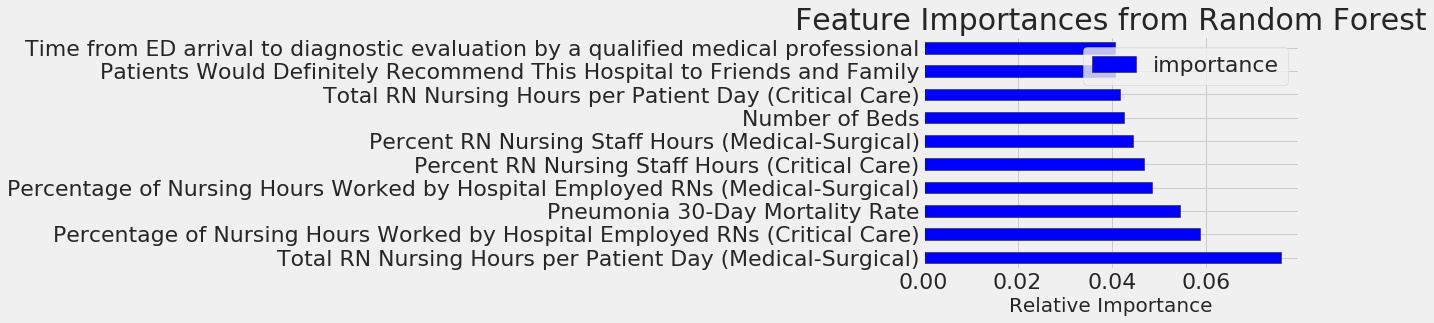

In [58]:
# To plot

figsize= (12, 10)

plt.style.use('fivethirtyeight')

# Plot the 10 most important features in a horizontal bar chart

feature_results.loc[:9, :].plot(x = 'feature', y = 'importance', 

                                 edgecolor = 'k',

                                 kind='barh', color = 'blue');

plt.xlabel('Relative Importance', size = 20); plt.ylabel('')

plt.title('Feature Importances from Random Forest', size = 30);

Now that we have a working model, we 'pickle' it so that we can add it to the back-end of the web app and the app won't need to retrain the model each time a user visits the website!

In [111]:
import pickle
file = open('rf_week5.sav', 'wb')
pickle.dump(model, file)
file.close()

In [59]:
y_pred=model.predict(X_test)

In [60]:
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix

array([[ 9,  3],
       [ 5, 20]])

Text(0.5, 8.5, 'Predicted label')

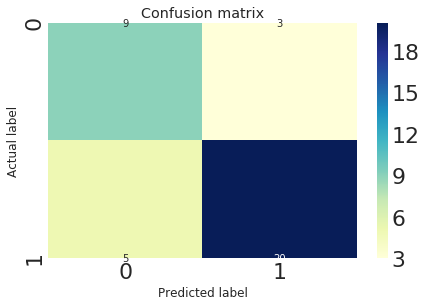

In [61]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("bottom")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')


In [62]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))

Accuracy: 0.7837837837837838
Precision: 0.8695652173913043
Recall: 0.8


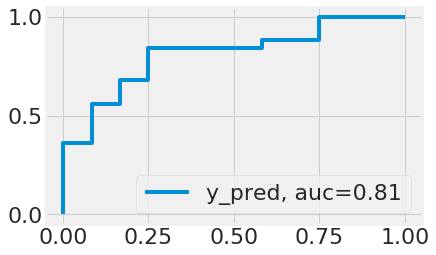

In [63]:
y_pred_proba = randomforest.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="y_pred, auc="+str(auc))
plt.legend(loc=4)
plt.show()

Model performance looks reasonable here with a recall of 0.8. The cost of false negatives is high because hospitals may not take action if we predict wrong, and then they would spend a lot of time and money training new nurses, which cost may have been reduced or avoided with some insights into what features are driving their turnoever. Next, I will extract the most important features using drop-column cross-validation. 

In [64]:
from sklearn.metrics import accuracy_score
from rfpimp import *

rf.fit(X_train, y_train)

def mkdf(columns, importances):
    I = pd.DataFrame(data={'Feature':columns, 'Importance':importances})
    I = I.set_index('Feature')
    I = I.sort_values('Importance', ascending=False)
    return I

def dropcol_importances(rf, X_train, y_train):
    rf_ = clone(rf)
    rf_.random_state = 999
    rf_.fit(X_train, y_train)
    baseline = rf_.oob_score_
    imp = []
    for col in X_train.columns:
        X = X_train.drop(col, axis=1)
        rf_ = clone(rf)
        rf_.random_state = 999
        rf_.fit(X, y_train)
        o = rf_.oob_score_
        imp.append(baseline - o)
    return np.array(imp)

def classifier_dropping_importances_cv(rf, X_train, y_train, k=5):
    rf_ = clone(rf)
    rf.random_state = 999
    rf_.fit(X_train, y_train)
    
    cvscore = cross_val_score(clone(rf), X_train, y_train, cv=k, scoring='accuracy')
    m_base = cvscore.mean()
    print(f"{k}-fold cross-validation accuracy {m_base:.4f}")
                              
    imp = []
    for col in X_train.columns:
        X = X_train.drop(col, axis=1)
        rf_ = clone(rf)
        rf_.random_state = 999
        rf_.fit(X, y_train)
        
        cvscore = cross_val_score(clone(rf_), X, y_train, cv=5, scoring='accuracy')
        m = cvscore.mean()
        print(f"drop {col} {k}-fold cross-validation accuracy {m:.4f}")
        imp.append(m_base - m)
        
    return np.array(imp)

In [ ]:
!pip install rfpimp

0.6301369863013698


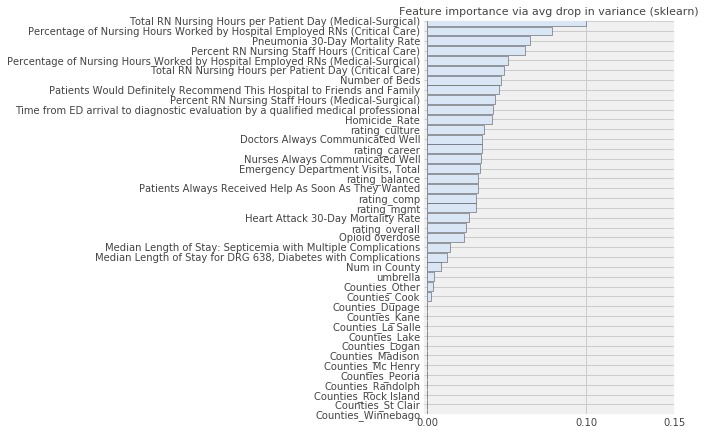

In [67]:
print(rf.oob_score_)
I = mkdf(X_train.columns,rf.feature_importances_)            
viz = plot_importances(I, vscale=.8, title="Feature importance via avg drop in variance (sklearn)")

In [68]:
Iall = pd.DataFrame(data={"columns":X_test.columns, "importances":rf.feature_importances_})
Iall = Iall.set_index("columns")
Iall = Iall.sort_values('importances', ascending=False)
I5 = Iall.head(10)



In [122]:
print(I5) #a little different than the default feature importances

                                                    importances
columns                                                        
Total RN Nursing Hours per Patient Day (Medical...     0.096490
Percentage of Nursing Hours Worked by Hospital ...     0.075812
Pneumonia 30-Day Mortality Rate                        0.062568
Percent RN Nursing Staff Hours (Critical Care)         0.059235
Percentage of Nursing Hours Worked by Hospital ...     0.048941
Total RN Nursing Hours per Patient Day (Critica...     0.046731
Number of Beds                                         0.044862
Patients Would Definitely Recommend This Hospit...     0.043362
Percent RN Nursing Staff Hours (Medical-Surgical)      0.041046
Time from ED arrival to diagnostic evaluation b...     0.039777


In [69]:
I5.head(10)
#I5.info()
I5.columns
I5['index'] =I5.index

Text(1.0, 1, 'Feature importance')

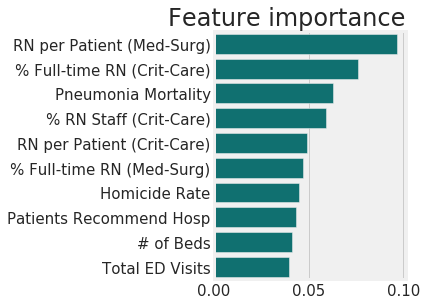

In [70]:
ordered_I5= I5.sort_values(by='importances', ascending=False)
ordered_I5['features'] = ['RN per Patient (Med-Surg)', 
        '% Full-time RN (Crit-Care)',
       'Pneumonia Mortality',
       '% RN Staff (Crit-Care)',
       'RN per Patient (Crit-Care)',
       '% Full-time RN (Med-Surg)',
       'Homicide Rate',
       'Patients Recommend Hosp',
        '# of Beds',
       'Total ED Visits']
ordered_I5.reset_index().sort_values('features')
params = {'axes.titlesize':'24',
          'xtick.labelsize':'15',
          'ytick.labelsize':'15'}
matplotlib.rcParams.update(params)
sns.barplot(data=ordered_I5, x='importances', y= 'features', orient = 'h', color='teal')
plt.ylabel('')
plt.xlabel('')
plt.tight_layout()
plt.title("Feature importance", loc='right')

In [71]:
ordered_I5.head()

,importances,index,features
columns,,,
Total RN Nursing Hours per Patient Day (Medical-Surgical),0.096490,Total RN Nursing Hours per Patient Day (Medica...,RN per Patient (Med-Surg)
Percentage of Nursing Hours Worked by Hospital Employed RNs (Critical Care),0.075812,Percentage of Nursing Hours Worked by Hospital...,% Full-time RN (Crit-Care)
Pneumonia 30-Day Mortality Rate,0.062568,Pneumonia 30-Day Mortality Rate,Pneumonia Mortality
Percent RN Nursing Staff Hours (Critical Care),0.059235,Percent RN Nursing Staff Hours (Critical Care),% RN Staff (Crit-Care)
Percentage of Nursing Hours Worked by Hospital Employed RNs (Medical-Surgical),0.048941,Percentage of Nursing Hours Worked by Hospital...,RN per Patient (Crit-Care)
